# First Example

In [20]:
import pandas as pd
dataset = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species'])


In [6]:
dataset['species'] = pd.Categorical(dataset['species']).codes
dataset = dataset.sample(frac = 1, random_state=1234)
train_input = dataset.values[:120, :4]
train_target = dataset.values[:120, 4]

test_input = dataset.values[120:, :4]
test_target = dataset.values[120:, 4]

In [8]:
# torch.cuda.is_available()

False

In [7]:
import torch

torch.manual_seed(1234)
hidden_units = 5
net = torch.nn.Sequential(torch.nn.Linear(4, hidden_units), torch.nn.ReLU(), torch.nn.Linear(hidden_units, 3))

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1, momentum = 0.9)
epochs = 50
for epoch in range(epochs):
    inputs = torch.autograd.Variable(torch.Tensor(train_input).float())
    targets = torch.autograd.Variable(torch.Tensor(train_target).long())
    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets)
    loss.backward()
    optimizer.step()
    if epoch == 0 or (epoch + 1) % 10 == 0:
        print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))

Epoch 1 Loss: 1.2181
Epoch 10 Loss: 0.6745
Epoch 20 Loss: 0.2447
Epoch 30 Loss: 0.1397
Epoch 40 Loss: 0.1001
Epoch 50 Loss: 0.0855


In [11]:
import numpy as np

inputs = torch.autograd.Variable(torch.Tensor(test_input).float())
targets = torch.autograd.Variable(torch.Tensor(test_target).long())

optimizer.zero_grad()
out = net(inputs)
p, predicted = torch.max(out.data, 1)

In [19]:
error_count  =test_target.size - np.count_nonzero((targets == predicted).numpy())
print('Errors : %d; Accuracy: %d%%' % (error_count, 100* torch.sum(targets == predicted) / test_target.size))

Errors : 0; Accuracy: 100%


# GAN example (with Keras)

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist
from keras.layers import BatchNormalization, Input, Dense, Reshape, Flatten
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

# build generator function

In [29]:
def build_generator(latent_dim: int):
    """
    Build discriminator network
    :param latent_dim: latent vector size
    """
    model = Sequential([
        Dense(128, input_dim = latent_dim),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(256),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(512),
        LeakyReLU(alpha=0.2),
        BatchNormalization(momentum=0.8),
        Dense(np.prod((28,28,1)), activation='tanh'),
        # reshape to MNIST image size
        Reshape((28,28,1))
        ], name = 'generator')
    
    
    model.summary()
    # the latent input vector z
    z = Input(shape = (latent_dim,))
    generated = model(z)

    # build model from the input and output
    return Model(z, generated)



# build discriminator function

In [43]:
from ast import Not


def build_discriminator():
    """
    Build discriminator network
    """
    model = Sequential([
        Flatten(input_shape = (28,28,1)),
        Dense(256),
        LeakyReLU(alpha=0.2),
        Dense(128),
        LeakyReLU(alpha=0.2),
        Dense(1, activation='sigmoid')
        ], name= 'discriminator')
    
    model.summary()
    
    image = Input(shape=(28,28,1))
    output = model(image)
    return Model(image, output)

# GAN training function

In [41]:
def train(generator, discriminator, combined, steps, batch_size):
    """
    Train the GAN system
    :param generator: generator
    :param discriminator: discriminator
    :param combined: stacked generator and discriminator
    :param steps: number of alternating steps for training
    :param batch_size: size of the minibatch
    """
    # load the dataset
    (x_train, _), _ = mnist.load_data()
    # rescale in [-1,1] interval
    x_train = (x_train.astype(np.float32) - 127.5) / 127.5
    x_train = np.expand_dims(x_train, axis = -1)
    # discriminator ground truths
    real = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    latent_dim = generator.input_shape[1]

    for step in range(steps):
        # Train the discriminator

        # Select a random batch of images
        real_images = x_train[np.random.randint(0, x_train.shape[0], batch_size)]
        # Random batch of noise
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        # Generate a batch of new images
        generated_images = generator.predict(noise)
        
        # Train the discriminator
        D_real_loss = discriminator.train_on_batch(real_images, real)
        D_fake_loss = discriminator.train_on_batch(generated_images, fake)
        D_loss = 0.5 * np.add(D_real_loss, D_fake_loss)

        # Train the generator
        # random latent vector z
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        # Note that we use the "valid" labels for the generated images
        # Thats because we try to maximize the discriminator loss
        G_loss = combined.train_on_batch(noise, real)

        # Display progress
        print("%d [Discriminator loss: %.4f%%, acc.: %.2f%%] [Generator loss: %.4f%%]" % (step, D_loss[0], 100 * D_loss[1], G_loss))

# Plot generated images

# Build generator, discriminator and the combined network.

In [49]:
def plot_generated_images(generator):
    """
    Display a nxn 2D manifold of digits
    :param generator: the generator
    """
    n = 10
    digit_size = 28
    # big array containing all images
    figure = np.zeros((digit_size*n, digit_size*n))
    latent_dim = generator.input_shape[1]
    # n*n random latent distributions
    noise = np.random.normal(0, 1, (n*n, latent_dim))
    # generate the images
    generated_images = generator.predict(noise)
    # fill the big array with images
    for i in range(n):
        for j in range(n):
            slice_i = slice(i * digit_size, (i + 1) * digit_size)
            slice_j = slice(j * digit_size, (j + 1) * digit_size)
            figure[slice_i, slice_j] = np.reshape(generated_images[i*n + j], (28,28))

    # plot the results
    plt.figure(figsize=(6,5))
    plt.axis('off')
    plt.imshow(figure, cmap= 'Greys_r')
    plt.show()


In [45]:
latent_dim = 64
# BUild and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.0002, beta_1=0.5), metrics = ['accuracy'])


# Build the generator
generator = build_generator(latent_dim)
# Generator input z
z = Input(shape= (latent_dim, ))
generated_image = generator(z)

# Only train the generator for the combined model
discriminator.trainable = False

# The discriminator takes generated image as input and determines validity
real_or_fake = discriminator(generated_image)

# Stack the generator and discriminator in a combined model
# Trains the generator to deceive the discriminator
combined = Model(z, real_or_fake)
combined.compile(loss = 'binary_crossentropy', optimizer = Adam(lr = 0.0002, beta_1=0.5))

# Train the GAN system
train(generator = generator, discriminator = discriminator, combined = combined, steps = 15000, batch_size = 128)


Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 256)               200960    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 233985 (914.00 KB)
Trainable params: 23

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 128)               0         
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_1 (Bat  (None, 256)               1024      
 chNormalization)                                        

4/4 [==============================] - 2s 13ms/step
0 [Discriminator loss: 0.7210%, acc.: 50.00%] [Generator loss: 0.6991%]
4/4 [==============================] - 0s 4ms/step
1 [Discriminator loss: 0.3175%, acc.: 89.45%] [Generator loss: 0.5837%]
4/4 [==============================] - 0s 6ms/step
2 [Discriminator loss: 0.3319%, acc.: 80.47%] [Generator loss: 0.5178%]
4/4 [==============================] - 0s 7ms/step
3 [Discriminator loss: 0.3714%, acc.: 68.75%] [Generator loss: 0.5480%]
4/4 [==============================] - 0s 7ms/step
4 [Discriminator loss: 0.4050%, acc.: 60.16%] [Generator loss: 0.6425%]
4/4 [==============================] - 0s 5ms/step
5 [Discriminator loss: 0.3835%, acc.: 66.80%] [Generator loss: 0.8470%]
4/4 [==============================] - 0s 5ms/step
6 [Discriminator loss: 0.3074%, acc.: 82.42%] [Generator loss: 1.1462%]
4/4 [==============================] - 0s 5ms/step
7 [Discriminator loss: 0.2103%, acc.: 98.05%] [Generator loss: 1.5206%]
4/4 [==========

2024-03-20 12:15:46.408575: W tensorflow/core/data/root_dataset.cc:297] Optimization loop failed: CANCELLED: Operation was cancelled


3566 [Discriminator loss: 0.6813%, acc.: 56.64%] [Generator loss: 0.8268%]
4/4 [==============================] - 0s 5ms/step
3567 [Discriminator loss: 0.6962%, acc.: 53.12%] [Generator loss: 0.8380%]
4/4 [==============================] - 0s 5ms/step
3568 [Discriminator loss: 0.7033%, acc.: 51.56%] [Generator loss: 0.8179%]
4/4 [==============================] - 0s 6ms/step
3569 [Discriminator loss: 0.6821%, acc.: 58.20%] [Generator loss: 0.8342%]
4/4 [==============================] - 0s 5ms/step
3570 [Discriminator loss: 0.6828%, acc.: 57.03%] [Generator loss: 0.8052%]
4/4 [==============================] - 0s 6ms/step
3571 [Discriminator loss: 0.6760%, acc.: 55.47%] [Generator loss: 0.8134%]
4/4 [==============================] - 0s 4ms/step
3572 [Discriminator loss: 0.6922%, acc.: 55.08%] [Generator loss: 0.8216%]
4/4 [==============================] - 0s 8ms/step
3573 [Discriminator loss: 0.6841%, acc.: 57.03%] [Generator loss: 0.8486%]
4/4 [==============================] - 0s 1

2024-03-20 12:27:12.168141: W tensorflow/core/data/root_dataset.cc:297] Optimization loop failed: CANCELLED: Operation was cancelled


5873 [Discriminator loss: 0.7004%, acc.: 51.56%] [Generator loss: 0.8059%]
4/4 [==============================] - 0s 6ms/step
5874 [Discriminator loss: 0.6844%, acc.: 56.64%] [Generator loss: 0.7953%]
4/4 [==============================] - 0s 15ms/step
5875 [Discriminator loss: 0.6977%, acc.: 47.66%] [Generator loss: 0.8078%]
4/4 [==============================] - 0s 19ms/step
5876 [Discriminator loss: 0.7086%, acc.: 48.44%] [Generator loss: 0.7935%]
4/4 [==============================] - 0s 5ms/step
5877 [Discriminator loss: 0.6920%, acc.: 58.20%] [Generator loss: 0.7687%]
4/4 [==============================] - 0s 15ms/step
5878 [Discriminator loss: 0.7041%, acc.: 50.78%] [Generator loss: 0.8094%]
4/4 [==============================] - 0s 10ms/step
5879 [Discriminator loss: 0.7164%, acc.: 50.00%] [Generator loss: 0.8314%]
4/4 [==============================] - 0s 6ms/step
5880 [Discriminator loss: 0.7142%, acc.: 44.14%] [Generator loss: 0.7890%]
4/4 [==============================] - 

2024-03-20 12:45:14.366318: W tensorflow/core/data/root_dataset.cc:297] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 9ms/step
9279 [Discriminator loss: 0.7002%, acc.: 51.95%] [Generator loss: 0.7650%]
4/4 [==============================] - 0s 8ms/step
9280 [Discriminator loss: 0.6895%, acc.: 54.30%] [Generator loss: 0.7502%]
4/4 [==============================] - 0s 14ms/step
9281 [Discriminator loss: 0.6963%, acc.: 53.12%] [Generator loss: 0.7516%]
4/4 [==============================] - 0s 8ms/step
9282 [Discriminator loss: 0.6835%, acc.: 56.64%] [Generator loss: 0.7708%]
4/4 [==============================] - 0s 7ms/step
9283 [Discriminator loss: 0.6895%, acc.: 52.73%] [Generator loss: 0.7619%]
4/4 [==============================] - 0s 8ms/step
9284 [Discriminator loss: 0.6939%, acc.: 51.56%] [Generator loss: 0.7564%]
4/4 [==============================] - 0s 5ms/step
9285 [Discriminator loss: 0.6887%, acc.: 51.56%] [Generator loss: 0.7741%]
4/4 [==============================] - 0s 8ms/step
9286 [Discriminator loss: 0.6941%, acc.: 50.00%] [Generator loss: 

2024-03-20 13:17:29.033524: W tensorflow/core/data/root_dataset.cc:297] Optimization loop failed: CANCELLED: Operation was cancelled


4/4 [==============================] - 0s 9ms/step
14659 [Discriminator loss: 0.6868%, acc.: 55.86%] [Generator loss: 0.7822%]
4/4 [==============================] - 0s 6ms/step
14660 [Discriminator loss: 0.6982%, acc.: 51.17%] [Generator loss: 0.7588%]
4/4 [==============================] - 0s 6ms/step
14661 [Discriminator loss: 0.6853%, acc.: 59.38%] [Generator loss: 0.7841%]
4/4 [==============================] - 0s 10ms/step
14662 [Discriminator loss: 0.6800%, acc.: 56.25%] [Generator loss: 0.7935%]
4/4 [==============================] - 0s 7ms/step
14663 [Discriminator loss: 0.6817%, acc.: 58.20%] [Generator loss: 0.7933%]
4/4 [==============================] - 0s 6ms/step
14664 [Discriminator loss: 0.6869%, acc.: 52.34%] [Generator loss: 0.8010%]
4/4 [==============================] - 0s 9ms/step
14665 [Discriminator loss: 0.6882%, acc.: 51.56%] [Generator loss: 0.7874%]
4/4 [==============================] - 0s 6ms/step
14666 [Discriminator loss: 0.6978%, acc.: 53.12%] [Generato

4/4 [==============================] - 0s 23ms/step


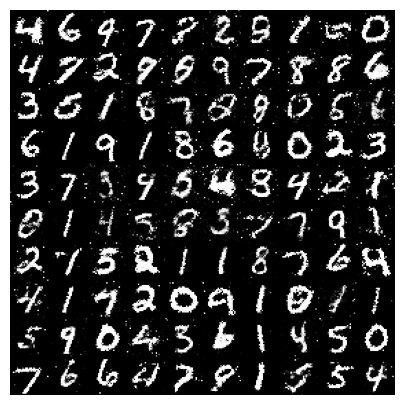

In [50]:
plot_generated_images(generator= generator)